# Imports

In [2]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from ta.trend import TRIXIndicator
from ta.trend import WMAIndicator
from ta.trend import CCIIndicator
from ta.volume import money_flow_index
import pandas_ta as pta
from ta.trend import MACD
from ta.momentum import PercentagePriceOscillator
from ta.momentum import ROCIndicator
from ta.volume import ChaikinMoneyFlowIndicator
from ta.trend import ADXIndicator

# Load Data

In [3]:
appl = yf.Ticker("AAPL")

In [4]:
appl_hist = appl.history(period="max")

# make pandas dataframe
apple_df = pd.DataFrame(appl_hist)

# Create Features

### Function Template for feature creation

In [5]:
def get_NAME_FEATUERE(df):
    #implementation of the feature-calculation
    # directly add the feature to the dataframe
    # no reurn needed
    pass

### Window Parameter

In [6]:
window = [5,7,9,11,13,15,17,19,21]

## Simple Moving Average SMA

In [7]:
def get_SMA(df):
    for i in window:
        df[f"SMA_{i}"] = df['Close'].rolling(window=i).mean()

## Exponential Moving Average

In [8]:
# a function for the exponential moving average
def get_EMA(df):
    for i in window:
        df[f"EMA_{i}"] = df['Close'].ewm(span=i, adjust=False).mean()   # adjust checken: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.ewm.html

## Triple Exponential Moving Average (TEMA)

In [9]:
def get_TRIX(df):
    for i in window:
        trix_values = TRIXIndicator(df['Close'], i).trix()
        df[f"TRIX_{i}"] = trix_values
    return df

## Mony Flow Index

The Money Flow Index (MFI) is a technical oscillator that uses price and volume data for identifying overbought or oversold signals in an asset. It can also be used to spot divergences which warn of a trend change in price. The oscillator moves between 0 and 100.

https://www.investopedia.com/terms/m/mfi.asp

In [10]:
# Function to calculate Money Flow Index
# Uses monex_flow_index from ta library

def get_MFI(df):
    for i in window:
        df[f"money_flow_index_{i}"] = money_flow_index(df['High'], df['Low'], df['Close'], df['Volume'], window=i)  

## Smoothed RSI

In [11]:
def get_RSI_smooth(df):
    """
    Momentum indicator
    As per https://www.investopedia.com/terms/r/rsi.asp
    RSI_1 = 100 - (100/ (1 + (avg gain% / avg loss%) ) )
    RSI_2 = 100 - (100/ (1 + (prev_avg_gain*13+avg gain% / prev_avg_loss*13 + avg loss%) ) )

    E.g. if period==6, first RSI starts from 7th index because difference of first row is NA
    http://cns.bu.edu/~gsc/CN710/fincast/Technical%20_indicators/Relative%20Strength%20Index%20(RSI).htm
    https://school.stockcharts.com/doku.php?id=technical_indicators:relative_strength_index_rsi
    Verified!
    """

    prev_rsi = np.inf
    prev_avg_gain = np.inf
    prev_avg_loss = np.inf
    rolling_count = 0

    def calculate_RSI(series, period):
        # nonlocal rolling_count
        nonlocal prev_avg_gain
        nonlocal prev_avg_loss
        nonlocal rolling_count

        # num_gains = (series >= 0).sum()
        # num_losses = (series < 0).sum()
        # sum_gains = series[series >= 0].sum()
        # sum_losses = np.abs(series[series < 0].sum())
        curr_gains = series.where(series >= 0, 0)  # replace 0 where series not > 0
        curr_losses = np.abs(series.where(series < 0, 0))
        avg_gain = curr_gains.sum() / period  # * 100
        avg_loss = curr_losses.sum() / period  # * 100
        rsi = -1

        if rolling_count == 0:
            # first RSI calculation
            rsi = 100 - (100 / (1 + (avg_gain / avg_loss)))
            # print(rolling_count,"rs1=",rs, rsi)
        else:
            # smoothed RSI
            # current gain and loss should be used, not avg_gain & avg_loss
            rsi = 100 - (100 / (1 + ((prev_avg_gain * (period - 1) + curr_gains.iloc[-1]) /
                                     (prev_avg_loss * (period - 1) + curr_losses.iloc[-1]))))
            # print(rolling_count,"rs2=",rs, rsi)

        # df['rsi_'+str(period)+'_own'][period + rolling_count] = rsi
        rolling_count = rolling_count + 1
        prev_avg_gain = avg_gain
        prev_avg_loss = avg_loss
        return rsi

    diff = df['Close'].diff()[1:]  # skip na
    for i in window:
        df['rsi_' + str(i)] = np.nan
        # df['rsi_'+str(period)+'_own_1'] = np.nan
        rolling_count = 0
        res = diff.rolling(i).apply(calculate_RSI, args=(i,), raw=False)
        df['rsi_' + str(i)][1:] = res

## Williams %R

https://de.wikipedia.org/wiki/Williams_%25R

In [12]:
def get_WILLIAMS_R(df):
    for i in window:
        highest_high = df['High'].rolling(window=i).max()
        lowest_low = df['Low'].rolling(window=i).min()
        df[f"williams_r_{i}"] = ((highest_high - df['Close']) / (highest_high - lowest_low)) * (-100)

## WMA - Weighted Moving Average

In [13]:
def get_WMA(df):
    for i in window:
        df[f"wma_{i}"] = WMAIndicator(df['Close'], i).wma()

## HMA - Hull Moving Average

In [14]:
#  ToDo: Formel und Resultate noch zu validieren!!

def get_HMA(df):
    """
    Berechnet den Hull Moving Average (HMA) und fügt ihn als neue Spalte zum DataFrame hinzu.
    
    """

    for i in window:
        wma1 = 2 * df['Close'].rolling(window=int(i / 2)).mean()
        wma2 = df['Close'].rolling(window=i).mean()
        diff = wma1 - wma2
        hma = diff.rolling(window=int(np.sqrt(i))).mean()
        df[f"hma_{i}"] = hma


## CCI - Commodity Channel Index

In [15]:
def get_CCI(df):
    for i in window:
        cci_values = CCIIndicator(df['High'], df['Low'], df['Close'], i).cci()
        df[f"cci_{i}"] = cci_values

## CMO - Chande Momentum Oszillator

In [16]:
# https://github.com/twopirllc/pandas-ta?tab=readme-ov-file#trend-18
# ToDo: Check!

def get_CMO(df):
    for i in window:
        df[f"cmo_{i}"] = pta.cmo(df['Close'], length=i)

## MACD - Moving Average Convergence Divergence

In [17]:
## https://www.lynxbroker.ch/boerse/trading/technische-analyse/technische-indikatoren/der-macd-indikator-bestimmen-sie-die-richtung-und-staerke-des-trends/

In [18]:
# ToDo: Check and Implementation for different windows

def get_MACD(df):
    macd_object = MACD(df['Close'])
    df['MACD'] = macd_object.macd()
    df['MACD_Signal'] = macd_object.macd_signal()
    df['MACD_Diff'] = macd_object.macd_diff()

## PPO - Percentage Price Oscillator

https://school.stockcharts.com/doku.php?id=technical_indicators:price_oscillators_ppo

In [19]:
# ToDo: Check and Implementation for different windows

def get_PPO(df):
        ppo_object = PercentagePriceOscillator(df['Close'])
        df[f"PPO"] = ppo_object.ppo()
        df[f"PPO_Histogram"] = ppo_object.ppo_hist()
        df[f"PPO_Signal"] = ppo_object.ppo_signal()

## ROC - Rate of Change

https://school.stockcharts.com/doku.php?id=technical_indicators:rate_of_change_roc_and_momentum

In [20]:
def get_ROC(df):
    for i in window:
        df[f"ROC_{i}"] = ROCIndicator(df['Close'], i).roc()

## CMI - Chaikin Money Flow

https://school.stockcharts.com/doku.php?id=technical_indicators:chaikin_money_flow_cmf

In [21]:
def get_CMF(df):
    for i in window:
        df[f"cmf_{i}"] = ChaikinMoneyFlowIndicator(df['High'], df['Low'], df['Close'], df['Volume'], i).chaikin_money_flow()

## ADX - Average Directional Movement Index (ADX)

http://stockcharts.com/school/doku.php?id=chart_school:technical_indicators:average_directional_index_adx

In [22]:
def get_ADX(df):
    for i in window:
        df[f"adx_{i}"] = ADXIndicator(df['High'], df['Low'], df['Close'], i).adx()
        df[f"adx_pos_{i}"] = ADXIndicator(df['High'], df['Low'], df['Close'], i).adx_pos()
        df[f"adx_neg_{i}"] = ADXIndicator(df['High'], df['Low'], df['Close'], i).adx_neg()
        
        

## Calculation of all features

In [24]:
def create_features(df):
    get_SMA(df)
    get_EMA(df)
    get_TRIX(df)
    get_MFI(df)
    get_RSI_smooth(df)
    get_WILLIAMS_R(df)
    get_WMA(df)
    get_HMA(df)
    get_CCI(df)
    get_CMO(df)
    get_MACD(df)
    get_PPO(df)
    get_ROC(df)
    get_CMF(df)
    get_ADX(df)
    
    

    print('Feature creation done!')

In [25]:
create_features(apple_df)

/var/folders/p3/w0lx7sbn5pd85k9cmydlynhc0000gn/T/ipykernel_16431/674612428.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['rsi_' + str(i)][1:] = res
/var/folders/p3/w0lx7sbn5pd85k9cmydlynhc0000gn/T/ipykernel_16431/674612428.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['rsi_' + str(i)][1:] = res
/var/folders/p3/w0lx7sbn5pd85k9cmydlynhc0000gn/T/ipykernel_16431/674612428.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-co

Feature creation done!


/var/folders/p3/w0lx7sbn5pd85k9cmydlynhc0000gn/T/ipykernel_16431/476938937.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"adx_{i}"] = ADXIndicator(df['High'], df['Low'], df['Close'], i).adx()
/var/folders/p3/w0lx7sbn5pd85k9cmydlynhc0000gn/T/ipykernel_16431/476938937.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"adx_pos_{i}"] = ADXIndicator(df['High'], df['Low'], df['Close'], i).adx_pos()
/var/folders/p3/w0lx7sbn5pd85k9cmydlynhc0000gn/T/ipykernel_16431/476938937.py:5: PerformanceWarning: DataFrame is highly f

In [26]:
apple_df

,Open,High,Low,Close,Volume,Dividends,Stock Splits,SMA_5,SMA_7,SMA_9,...,adx_neg_15,adx_17,adx_pos_17,adx_neg_17,adx_19,adx_pos_19,adx_neg_19,adx_21,adx_pos_21,adx_neg_21
Date,,,,,,,,,,,,,,,,,,,,,
1980-12-12 00:00:00-05:00,0.099192,0.099623,0.099192,0.099192,469033600,0.0,0.0,NaN,NaN,NaN,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1980-12-15 00:00:00-05:00,0.094448,0.094448,0.094017,0.094017,175884800,0.0,0.0,NaN,NaN,NaN,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1980-12-16 00:00:00-05:00,0.087548,0.087548,0.087116,0.087116,105728000,0.0,0.0,NaN,NaN,NaN,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1980-12-17 00:00:00-05:00,0.089273,0.089704,0.089273,0.089273,86441600,0.0,0.0,NaN,NaN,NaN,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1980-12-18 00:00:00-05:00,0.091861,0.092292,0.091861,0.091861,73449600,0.0,0.0,0.092292,NaN,NaN,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-04-05 00:00:00-04:00,169.589996,170.389999,168.949997,169.580002,42055200,0.0,0.0,169.384000,170.244284,170.252223,...,22.853155,20.234485,20.475501,23.550784,20.377930,20.346592,24.120542,20.142524,20.278869,24.585725
2024-04-08 00:00:00-04:00,169.029999,169.199997,168.240005,168.449997,37425500,0.0,0.0,169.067999,169.549999,169.985555,...,23.763900,19.627387,19.936935,24.324980,19.885194,19.872610,24.792941,19.746419,19.854710,25.179724
2024-04-09 00:00:00-04:00,168.699997,170.080002,168.350006,169.669998,42451200,0.0,0.0,169.234000,169.291428,169.981110,...,22.810202,18.798580,21.014066,23.477882,19.214514,20.826304,24.030076,19.203928,20.709803,24.485461


# Labeling

In [37]:
# Function to lable the data
# if i + 11 is the max value in the window, label as BUY
# if i + 11 is the min value in the window, label as SELL
# else label as HOLD
# Idea: Buy when the stock is at its lowest in the window, sell when it is at its highest

# Source: https://medium.com/@quantclubiitkgp/stock-buy-sell-hold-prediction-using-cnn-ee7b671f4ad3


def get_labels_END(df, windowSize=11):
   labels = [] 
   values = []
   for i in range(len(df.Close) - windowSize): 
      mx = df.Close.iloc[i]
      mn = df.Close.iloc[i]
      mxIndex, mnIndex = i, i
      for j in range(i + 1, i + windowSize + 1): 
         if df.Close.iloc[j] > mx:
               mx = df.Close.iloc[j]
               mxIndex = j
         if df.Close.iloc[j] < mn: 
               mn = df.Close.iloc[j] 
               mnIndex = j

      if mnIndex == i + 11:
         labels.append('SELL')
         values.append(i + 11)
      elif mxIndex == i + 11:
         labels.append('BUY')
         values.append(i + 11)
      else:
         labels.append('HOLD')
         values.append(i + 11)
   
   # Append 11 times a 999 to the end of the labels list
   for i in range(11):
      labels.append(999)

   # Append the labels to the dataframe from the start
   df['Labels_END'] = labels

   # Replace the 999 with NaN
   df['Labels_END'] = df['Labels_END'].replace(999, np.nan)

   print('Labeling END done!')

   return df


In [27]:
# Source: https://towardsdatascience.com/stock-market-action-prediction-with-convnet-8689238feae3


def get_labels_MID(df, col_name, window_size=11):
        """
        Data is labeled as per the logic in research paper
        Label code : BUY => 1, SELL => 0, HOLD => 2
        params :
            df => Dataframe with data
            col_name => name of column which should be used to determine strategy
        returns : nothing - df is modified directly
        """

        row_counter = 0
        total_rows = len(df)
        labels = np.zeros(total_rows)
        labels[:] = np.nan

        while row_counter < total_rows:
            if row_counter >= window_size - 1:
                window_begin = row_counter - (window_size - 1)
                window_end = row_counter
                window_middle = int((window_begin + window_end) / 2)

                min_ = np.inf
                min_index = -1
                max_ = -np.inf
                max_index = -1
                for i in range(window_begin, window_end + 1):
                    price = df.iloc[i][col_name]
                    if price < min_:
                        min_ = price
                        min_index = i
                    if price > max_:
                        max_ = price
                        max_index = i

                if max_index == window_middle:
                    labels[window_middle] = 0
                elif min_index == window_middle:
                    labels[window_middle] = 1
                else:
                    labels[window_middle] = 2

            row_counter = row_counter + 1

        # Add labels to the dataframe
        df['Labels_MID'] = labels

        # Replace the 0, 1, 2 with BUY, SELL, HOLD
        df['Labels_MID'] = df['Labels_MID'].replace(0, 'SELL')
        df['Labels_MID'] = df['Labels_MID'].replace(1, 'BUY')
        df['Labels_MID'] = df['Labels_MID'].replace(2, 'HOLD')
        

        print('Labeling MID done!') 

In [28]:
get_labels_MID(apple_df, 'Close')
#get_labels_END(apple_df)

Labeling MID done!


/var/folders/p3/w0lx7sbn5pd85k9cmydlynhc0000gn/T/ipykernel_16431/1539600692.py:48: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['Labels_MID'] = labels


KeyError: 'Labels_END'

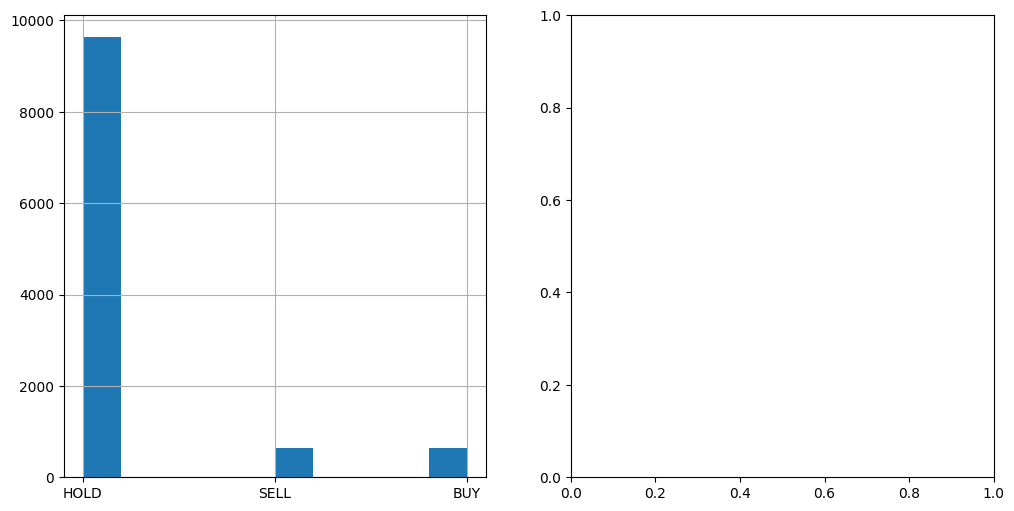

In [29]:
# make a subplot of the labeles MID and END
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
apple_df['Labels_MID'].hist(ax=ax[0])
apple_df['Labels_END'].hist(ax=ax[1])

# add a title to the subplot
ax[0].set_title('Labels MID')
ax[1].set_title('Labels END')


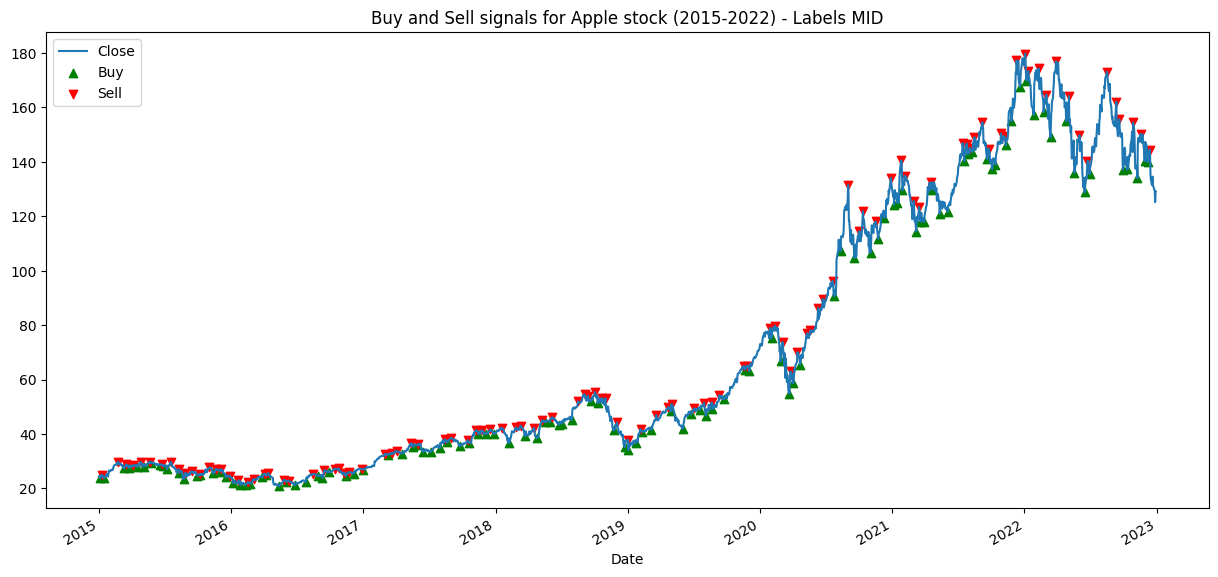

In [30]:
plt.figure(figsize=(15, 7))

# add buy and sell signals
# buy = green, sell = red
buy = apple_df[(apple_df['Labels_MID'] == 'BUY') & (apple_df.index >= '2015-01-01') & (apple_df.index <= '2022-12-31')]
sell = apple_df[(apple_df['Labels_MID'] == 'SELL') & (apple_df.index >= '2015-01-01') & (apple_df.index <= '2022-12-31')]
apple_df['Close']['2015':'2022'].plot()
plt.scatter(buy.index, buy['Close'], color='g', marker='^', alpha=1)
plt.scatter(sell.index, sell['Close'], color='r', marker='v', alpha=1)
plt.title('Buy and Sell signals for Apple stock (2015-2022) - Labels MID')
plt.legend(['Close', 'Buy', 'Sell'])
plt.show()



In [31]:
plt.figure(figsize=(15, 7))

# add buy and sell signals
# buy = green, sell = red
buy = apple_df[(apple_df['Labels_END'] == 'BUY') & (apple_df.index >= '2015-01-01') & (apple_df.index <= '2022-12-31')]
sell = apple_df[(apple_df['Labels_END'] == 'SELL') & (apple_df.index >= '2015-01-01') & (apple_df.index <= '2022-12-31')]
apple_df['Close']['2015':'2022'].plot()
plt.scatter(buy.index, buy['Close'], color='g', marker='^', alpha=1)
plt.scatter(sell.index, sell['Close'], color='r', marker='v', alpha=1)
plt.title('Buy and Sell signals for Apple stock (2015-2022) - Labels END')
plt.legend(['Close', 'Buy', 'Sell'])
plt.show()


KeyError: 'Labels_END'

<Figure size 1500x700 with 0 Axes>

## Feature Engineering

The reason behind having this step in our pipeline is that Feature engineering involves creating, transforming, or selecting the most relevant variables in your dataset to improve model performance. This process is critical because it enables the model to learn from the data more effectively, leading to better predictions and insights. Feature selection, in particular, trims down the feature set to keep only the most valuable attributes, reducing complexity, computation time, and the risk of overfitting. In essence, these techniques streamline the modelling process, making it more accurate, interpretable, and efficient, while also saving time and resources.
First, we Normalize our data set because Normalizing a dataset is crucial to ensure that all features are on a consistent scale, preventing one feature from dominating the analysis, improving model convergence, aiding in the interpretation of feature importance, making distance-based algorithms more reliable, and aligning with assumptions of regularisation techniques, all of which contribute to more effective and robust data analysis and machine learning.
Then we will just apply a small filter of variance with a threshold of 0.1 i.e. any feature which has a variance less than or equal to 0.1 will be removed from the dataset as having this low variance does not contribute much to detecting the trend in the dataset.

In [123]:
# Function to calculate the number of features

def calc_feature_number(features):
    features = len(features)
    return np.floor(np.sqrt(features)).astype(int)

In [124]:
list_features = list(apple_df.loc[:, 'Open':'adx_neg_21'].columns)
print('Total number of features: ', len(list_features))
print('Largest number of features that can be used in the model: ', calc_feature_number(list_features))
print(f"k = {calc_feature_number(list_features)**2}")

Total number of features:  148
Largest number of features that can be used in the model:  12
k = 144


In [125]:
### just copied from: https://towardsdatascience.com/stock-market-action-prediction-with-convnet-8689238feae3
### needs to be reworked and adapted to the features we want to use
### create function for this


from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from collections import Counter

df = apple_df.dropna()

list_features = list(df.loc[:, 'Open':'adx_neg_21'].columns)  # needs to be changed to the features you want to use
print('Total number of features', len(list_features))
x_train, x_test, y_train, y_test = train_test_split(df.loc[:, 'Open':'adx_neg_21'], df['Labels_MID'], train_size=0.8, 
                                                    test_size=0.2, random_state=2, shuffle=True, stratify=df['Labels_MID'])

train_split = 0.8

print('train_split =',train_split)
x_train, x_cv, y_train, y_cv = train_test_split(x_train, y_train, train_size=train_split, test_size=1-train_split, 
                                                random_state=2, shuffle=True, stratify=y_train)
mm_scaler = MinMaxScaler(feature_range=(0, 1)) # or StandardScaler?
x_train = mm_scaler.fit_transform(x_train)
x_cv = mm_scaler.transform(x_cv)
x_test = mm_scaler.transform(x_test)

print("Shape of x, y train/cv/test {} {} {} {} {} {}".format(x_train.shape, y_train.shape, x_cv.shape, y_cv.shape, x_test.shape, y_test.shape))


Total number of features 148
train_split = 0.8
Shape of x, y train/cv/test (6948, 148) (6948,) (1737, 148) (1737,) (2172, 148) (2172,)


# Feature Selection

Now the main part is that we will calculate the importance of each feature by using Random Forest Classifier and then reduce the feature size to 81.

A rough idea of how random forest works is for each decision point (split) in each tree, the Random Forest algorithm measures the decrease in impurity(Gini impurity) resulting from the split. The impurity reduction brought about by each feature is averaged across all the trees in the forest. Features that consistently reduce impurity more effectively when used in splits are considered more important

In [126]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

In [127]:
from sklearn.feature_selection import SelectKBest, chi2

# Anwenden der Feature Selection mit SelectKBest und Chi-Quadrat-Test
k = 144  # Anzahl der gewünschten Merkmale
selector = SelectKBest(chi2, k=k)
X_new = selector.fit_transform(x_train, y_train)

# Index der ausgewählten Merkmale
selected_feature_indices = selector.get_support(indices=True)

# Ausgabe der Indizes der ausgewählten Merkmale
print("Indizes der ausgewählten Merkmale:")
print(selected_feature_indices)

Indizes der ausgewählten Merkmale:
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  34  35  36  37  38
  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54  55  56
  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72  73  74
  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92
  93  94  95  96  97  99 100 101 102 103 104 105 106 107 108 109 110 111
 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129
 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147]


In [128]:
len(selected_feature_indices)

144

In [129]:
# only use the selected features
x_train = x_train[:, selected_feature_indices]
x_cv = x_cv[:, selected_feature_indices]
x_test = x_test[:, selected_feature_indices]



## Feature Importamce in Prediction

Used mutual info classification for creating heat map for our image. Basically it tells us which part of the image is most useful to the model (will explain this part more in further ). (https://medium.com/@quantclubiitkgp/stock-buy-sell-hold-prediction-using-cnn-ee7b671f4ad3)

> keine Ahnung was er damit meint und warum er das macht??!

## Image Creation

In [130]:
# Function to reshape the data
# Creates a 3D array (x, y and images for each row) for the CNN

def reshape_as_image(x, img_width, img_height):
    x_temp = np.zeros((len(x), img_height, img_width))
    for i in range(x.shape[0]):
        # print(type(x), type(x_temp), x.shape)
        x_temp[i] = np.reshape(x[i], (img_height, img_width))

    return x_temp

In [131]:
dim = int(np.sqrt(k))
x_train = reshape_as_image(x_train, dim, dim)
x_cv = reshape_as_image(x_cv, dim, dim)
x_test = reshape_as_image(x_test, dim, dim)
# adding a 1-dim for channels (3)
x_train = np.stack((x_train,) * 3, axis=-1)
x_test = np.stack((x_test,) * 3, axis=-1)
x_cv = np.stack((x_cv,) * 3, axis=-1)
print("final shape of x, y train/test {} {} {} {}".format(x_train.shape, y_train.shape, x_test.shape, y_test.shape))


final shape of x, y train/test (6948, 12, 12, 3) (6948,) (2172, 12, 12, 3) (2172,)


In [134]:
x_train.shape

(6948, 12, 12, 3)

/var/folders/p3/w0lx7sbn5pd85k9cmydlynhc0000gn/T/ipykernel_16431/408720151.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax[i].set_title(y_train[index])


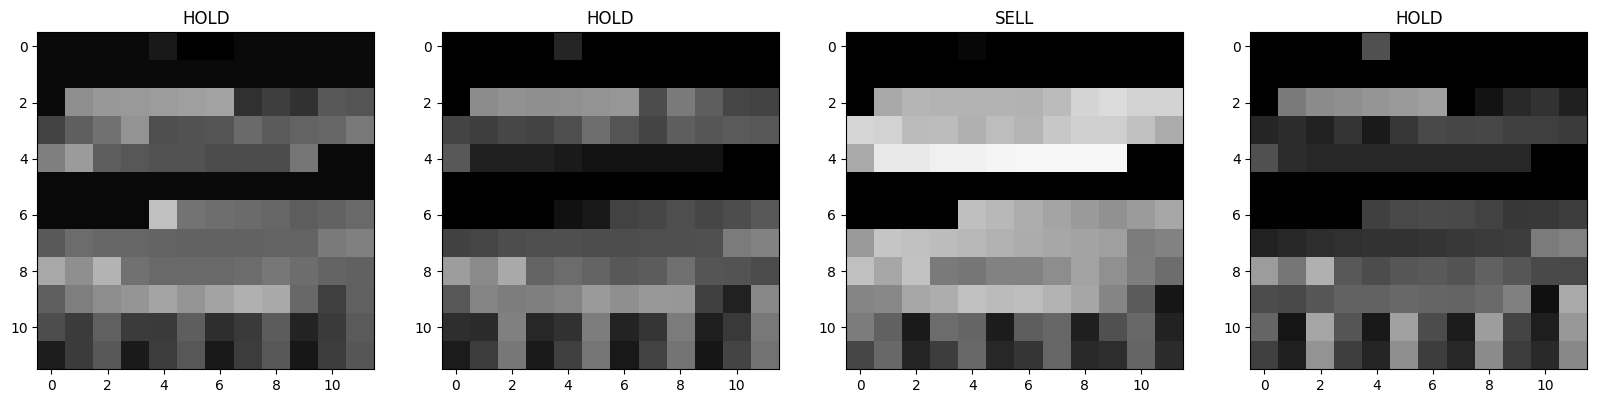

In [133]:
# Subplot with 4 plots in a row with random data

fig, ax = plt.subplots(1, 4, figsize=(20, 5))
for i in range(4):
    index = np.random.randint(0, x_train.shape[0])
    ax[i].imshow(x_train[index])
    ax[i].set_title(y_train[index])
plt.show()


## CNN

## Trading Bot Implementation

In [109]:
# a simple CNN model
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(dim, dim, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.fit(x_train, y_train, validation_data=(x_cv, y_cv), epochs=10)


Epoch 1/10


/Users/flaviopfister/anaconda3/envs/banking/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(
2024-04-12 08:37:51.853535: W tensorflow/core/framework/op_kernel.cc:1816] OP_REQUIRES failed at cast_op.cc:122 : UNIMPLEMENTED: Cast string to float is not supported


UnimplementedError: Graph execution error:

Detected at node compile_loss/sparse_categorical_crossentropy/Cast defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "/Users/flaviopfister/anaconda3/envs/banking/lib/python3.11/site-packages/ipykernel_launcher.py", line 18, in <module>

  File "/Users/flaviopfister/anaconda3/envs/banking/lib/python3.11/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/Users/flaviopfister/anaconda3/envs/banking/lib/python3.11/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/Users/flaviopfister/anaconda3/envs/banking/lib/python3.11/site-packages/tornado/platform/asyncio.py", line 205, in start

  File "/Users/flaviopfister/anaconda3/envs/banking/lib/python3.11/asyncio/base_events.py", line 608, in run_forever

  File "/Users/flaviopfister/anaconda3/envs/banking/lib/python3.11/asyncio/base_events.py", line 1936, in _run_once

  File "/Users/flaviopfister/anaconda3/envs/banking/lib/python3.11/asyncio/events.py", line 84, in _run

  File "/Users/flaviopfister/anaconda3/envs/banking/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue

  File "/Users/flaviopfister/anaconda3/envs/banking/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 534, in process_one

  File "/Users/flaviopfister/anaconda3/envs/banking/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell

  File "/Users/flaviopfister/anaconda3/envs/banking/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 359, in execute_request

  File "/Users/flaviopfister/anaconda3/envs/banking/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 778, in execute_request

  File "/Users/flaviopfister/anaconda3/envs/banking/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 446, in do_execute

  File "/Users/flaviopfister/anaconda3/envs/banking/lib/python3.11/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/Users/flaviopfister/anaconda3/envs/banking/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3075, in run_cell

  File "/Users/flaviopfister/anaconda3/envs/banking/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3130, in _run_cell

  File "/Users/flaviopfister/anaconda3/envs/banking/lib/python3.11/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner

  File "/Users/flaviopfister/anaconda3/envs/banking/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3334, in run_cell_async

  File "/Users/flaviopfister/anaconda3/envs/banking/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3517, in run_ast_nodes

  File "/Users/flaviopfister/anaconda3/envs/banking/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3577, in run_code

  File "/var/folders/p3/w0lx7sbn5pd85k9cmydlynhc0000gn/T/ipykernel_16431/4190766947.py", line 16, in <module>

  File "/Users/flaviopfister/anaconda3/envs/banking/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/Users/flaviopfister/anaconda3/envs/banking/lib/python3.11/site-packages/keras/src/backend/tensorflow/trainer.py", line 329, in fit

  File "/Users/flaviopfister/anaconda3/envs/banking/lib/python3.11/site-packages/keras/src/backend/tensorflow/trainer.py", line 122, in one_step_on_iterator

  File "/Users/flaviopfister/anaconda3/envs/banking/lib/python3.11/site-packages/keras/src/backend/tensorflow/trainer.py", line 110, in one_step_on_data

  File "/Users/flaviopfister/anaconda3/envs/banking/lib/python3.11/site-packages/keras/src/backend/tensorflow/trainer.py", line 60, in train_step

  File "/Users/flaviopfister/anaconda3/envs/banking/lib/python3.11/site-packages/keras/src/trainers/trainer.py", line 323, in compute_loss

  File "/Users/flaviopfister/anaconda3/envs/banking/lib/python3.11/site-packages/keras/src/trainers/compile_utils.py", line 605, in __call__

  File "/Users/flaviopfister/anaconda3/envs/banking/lib/python3.11/site-packages/keras/src/trainers/compile_utils.py", line 641, in call

  File "/Users/flaviopfister/anaconda3/envs/banking/lib/python3.11/site-packages/keras/src/losses/loss.py", line 38, in __call__

  File "/Users/flaviopfister/anaconda3/envs/banking/lib/python3.11/site-packages/keras/src/utils/tree.py", line 239, in map_structure

  File "/Users/flaviopfister/anaconda3/envs/banking/lib/python3.11/site-packages/optree/ops.py", line 594, in tree_map

  File "/Users/flaviopfister/anaconda3/envs/banking/lib/python3.11/site-packages/keras/src/losses/loss.py", line 39, in <lambda>

  File "/Users/flaviopfister/anaconda3/envs/banking/lib/python3.11/site-packages/keras/src/ops/core.py", line 495, in convert_to_tensor

  File "/Users/flaviopfister/anaconda3/envs/banking/lib/python3.11/site-packages/keras/src/backend/tensorflow/core.py", line 121, in convert_to_tensor

Cast string to float is not supported
	 [[{{node compile_loss/sparse_categorical_crossentropy/Cast}}]] [Op:__inference_one_step_on_iterator_1471]